### [Robustness: Outliers & Modeling Errors](https://scikit-learn.org/stable/modules/linear_model.html#robustness-regression-outliers-and-modeling-errors)
- Factors to consider:
    - Are outliers in X, or in y?
    - "Breakdown point": # of outlier points vs error amplitude
- Three estimators to consider. When in doubt, use [__RANSAC__](https://scikit-learn.org/stable/modules/linear_model.html#ransac-regression).
    - [__Huber__](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html#sklearn.linear_model.HuberRegressor): faster (unless #samples is >> #features)
        - applies a linear loss to outliers
        - samples are classified as inliers if absolute error < a given threshold
        - does not ignore outlier effect, but gives lesser weight to them.
        - loss function: $\min_{w, \sigma} {\sum_{i=1}^n\left(\sigma + H_{\epsilon}\left(\frac{X_{i}w - y_{i}}{\sigma}\right)\sigma\right) + \alpha {||w||_2}^2}$
        - where $\begin{split}H_{\epsilon}(z) = \begin{cases}
       z^2, & \text {if } |z| < \epsilon, \\
       2\epsilon|z| - \epsilon^2, & \text{otherwise}
\end{cases}\end{split}$
        - best practice: set `epsilon`=1.35 for 95% statistical efficiency.
    - [__RANSAC (random sample consensus)__](https://scikit-learn.org/stable/modules/linear_model.html#ransac-regression): 
        - non-deterministic, results a result with a given probability - which depends on the number of iterations (`max_trials`).
        - splits dataset into inliers (may be noisy) & outliers. resulting model determined from inliers.
        - faster than Theil Sen. Scales well with #samples. Also handles large y-direction outliers well.
    - [__Theil Sen__](https://scikit-learn.org/stable/modules/linear_model.html#theil-sen-regression): better on medium-size X-direction outliers. (But will disappear in high-dimensional problems.)

### [Example: RANSAC](https://scikit-learn.org/stable/modules/linear_model.html#ransac-random-sample-consensus)
- fits a model from __random subsets__ of inliers from a complete dataset.
- Returns a reasonable result with a certain probability (dependent on `max_trials`).
- Algorithm splits the dataset into inliers (subject to noise) & outliers (due to erroneous measures or invalid data assumptions).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets, linear_model
n_samples = 1000
n_outliers = 50

In [2]:
X, y, coef = datasets.make_regression(
    n_samples=n_samples,
    n_features=1,
    n_informative=1,
    noise=10,
    coef=True,
    random_state=0,
)

# Add outlier data
np.random.seed(0)
X[:n_outliers] =  3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 +  10 * np.random.normal(size=n_outliers)

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)



Estimated coefficients (true, linear regression, RANSAC):
82.1903908407869 [54.17236387] [82.08533159]


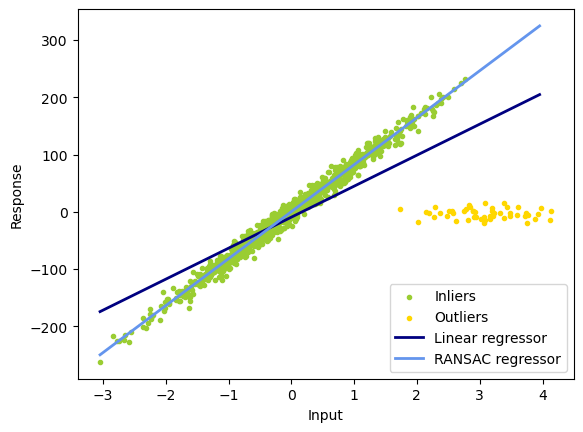

In [3]:
lw = 2
plt.scatter(
    X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(line_X, line_y, color="navy", linewidth=lw, label="Linear regressor")
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=lw,
    label="RANSAC regressor",
)
plt.legend(loc="lower right")
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

### [Example: Theil Sen regression](https://scikit-learn.org/stable/modules/linear_model.html#theil-sen-estimator-generalized-median-based-estimator)
- Robust to multivariate outliers - robustness degrades quickly with dimensionality.
- Non-parametric method; makes no assumptions about underlying data distribution.
- Univariate use case: Theil-Sen has a breakdown point ~29% (ie, can tolerate arbitrarily corrupted data up to ~29%.)

### [Example: Theil Sen regression](https://scikit-learn.org/stable/auto_examples/linear_model/plot_theilsen.html#sphx-glr-auto-examples-linear-model-plot-theilsen-py)

In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import TheilSenRegressor as TSR
from sklearn.linear_model import RANSACRegressor as RR

In [5]:
# example: only y outliers
# model: y = 3*x + N(2,0.1**2)
np.random.seed(0)
n_samples = 200; 
w = 3.
c = 2.
x         =     np.random.randn(n_samples)
noise     = 0.1*np.random.randn(n_samples)
y         = w*x+c+noise
# 10% outliers
y[-20:]  += -20*x[-20:]
X         = x[:, np.newaxis]

Text(0.5, 1.0, 'corrupt y values')

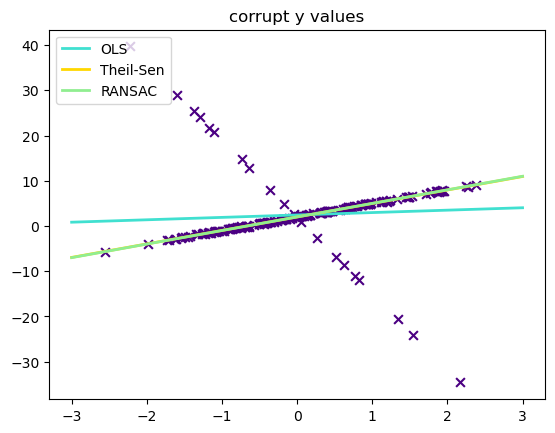

In [6]:
plt.scatter(x,y,color='indigo',marker='x',s=40)
line_x = np.array([-3,+3])

for name,model in [('OLS',LR()), 
                   ('Theil-Sen', TSR(random_state=42)), 
                   ('RANSAC', RR(random_state=42))]:
    model.fit(X,y)
    y_pred = model.predict(line_x.reshape(2,1))
    
    plt.plot(line_x, y_pred, 
             color={'OLS': 'turquoise', 
                    'Theil-Sen': 'gold', 
                    'RANSAC': 'lightgreen'}[name],
             linewidth=2,
             label=name
            )
plt.legend(loc='upper left'); plt.title('corrupt y values')

In [7]:
# only X outliers (10%)
# model: y = 3*x+N(2,0.1**2)
x        =     np.random.randn(n_samples)
noise    = 0.1*np.random.randn(n_samples)
y        = 3*x+2+noise
x[-20:]  = 9.9
y[-20:] += 22
X        = x[:, np.newaxis]

Text(0.5, 1.0, 'corrupt X values')

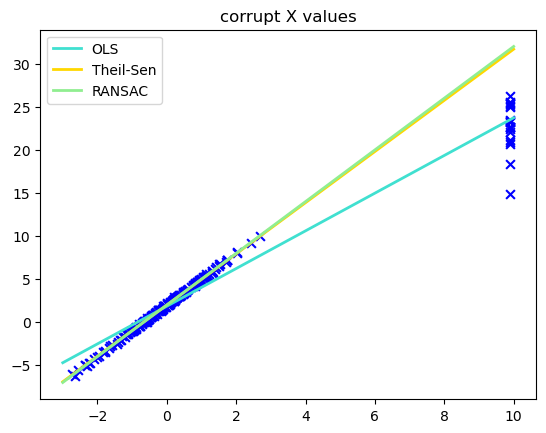

In [8]:
plt.figure()
plt.scatter(x,y,color='blue',marker='x',s=40)

line_x = np.array([-3,10])
for name,model in [('OLS',LR()), 
                   ('Theil-Sen', TSR(random_state=42)), 
                   ('RANSAC', RR(random_state=42))]:
    model.fit(X,y)
    y_pred = model.predict(line_x.reshape(2,1))
    
    plt.plot(line_x, y_pred, 
             color={'OLS': 'turquoise', 
                    'Theil-Sen': 'gold', 
                    'RANSAC': 'lightgreen'}[name],
             linewidth=2,
             label=name
            )
plt.legend(loc='upper left'); plt.title("corrupt X values")

### [Huber regression](https://scikit-learn.org/stable/modules/linear_model.html#huber-regression)
- Different than Ridge - it applies a linear loss to outliers. Samples are considered to be inliers if the absolute error is less than a given threshold.
- Different from Theil-Sen and RANSAC: it doesn't ignore outliers, but gives them a lesser weight.

### [Example: Huber vs Ridge Regression](https://scikit-learn.org/stable/auto_examples/linear_model/plot_huber_vs_ridge.html)
- shows how predictions are influenced by outliers (Huber: less so). `epsilon` controls the decision function.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression as MR
from sklearn.linear_model import HuberRegressor as HR 
from sklearn.linear_model import Ridge as R

In [10]:
rng   = np.random.RandomState(0)
X,y   = MR(n_samples=20, n_features=1, random_state=0, noise=4.0, bias=100.0)

# Add four strong outliers to the dataset.
X_outliers         = rng.normal(0, 0.5, size=(4, 1))
y_outliers         = rng.normal(0, 2.0, size=4)
X_outliers[:2, :] += X.max() + X.mean() / 4.
X_outliers[2:, :] += X.min() - X.mean() / 4.
y_outliers[:2]    += y.min() - y.mean() / 4.
y_outliers[2:]    += y.max() + y.mean() / 4.
X                  = np.vstack(     (X, X_outliers))
y                  = np.concatenate((y, y_outliers))

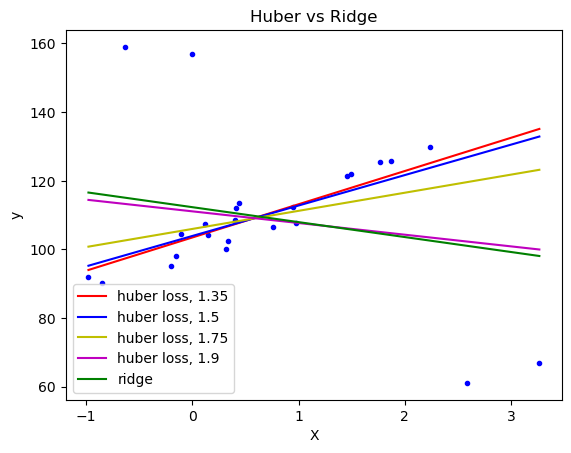

In [12]:
plt.plot(X, y, 'b.')

# plot huber regressor over a range of values
colors = ['r-', 'b-', 'y-', 'm-']
x      = np.linspace(X.min(), X.max(), 7)

for k, epsilon in enumerate([1.35, 1.5, 1.75, 1.9]):
    huber = HR(alpha=0.0, epsilon=epsilon)
    huber.fit(X, y)
    coef_ = huber.coef_ * x + huber.intercept_
    plt.plot(x, coef_, colors[k], label="huber loss, %s" % epsilon)

# Fit a ridge regressor for comparison
ridge = R(alpha=0.0, random_state=0)
ridge.fit(X, y)

#coef_ridge = ridge.coef_
coef_ = ridge.coef_ * x + ridge.intercept_

plt.plot(x, coef_, 'g-', label="ridge")
plt.title("Huber vs Ridge")
plt.xlabel("X"); plt.ylabel("y"); plt.legend(loc=0); plt.show()